# NanoGPT Model Evaluation

This notebook loads and evaluates the trained NanoGPT model on the Shakespeare dataset.
We'll perform text generation, calculate perplexity, and analyze model performance.

## 1. Import Required Libraries

Import PyTorch, transformers, and other necessary libraries for model loading and evaluation.

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import yaml
import os
import sys
import time
import math
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Add the baselines directory to path so we can import the model
sys.path.append('../baselines')
from nanogpt.model import GPT, GPTConfig

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

PyTorch version: 2.8.0+cpu
CUDA available: False


## 2. Load Model Configuration

Load the model configuration file and set up device (CPU/GPU) for inference.

In [21]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Define paths
MODEL_PATH = '../checkpoints/baseline_nanogpt/baseline_nanogpt.pt'
META_PATH = '../checkpoints/baseline_nanogpt/nanogpt_meta.pkl'
CONFIG_PATH = '../baselines/nanogpt/shakespeare-char/config.yaml'

# Load training configuration
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

print("Training configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Using device: cpu
Training configuration:
  _wandb: {'value': {'cli_version': '0.21.1', 'e': {'oynd0ssilynh77cjz36inn4q3atntnbg': {'args': ['config/train_shakespeare_char.py', '--dtype=float16', '--init_from=scratch', '--max_iters=1000'], 'codePath': 'train.py', 'codePathLocal': 'train.py', 'cpu_count': 1, 'cpu_count_logical': 2, 'cudaVersion': '12.4', 'disk': {'/': {'total': '120942624768', 'used': '42066935808'}}, 'email': 'sofiia.nikolenko@campus.lmu.de', 'executable': '/usr/bin/python3', 'git': {'commit': '93a43d9a5c22450bbf06e78da2cb6eeef084b717', 'remote': 'https://github.com/karpathy/nanoGPT'}, 'gpu': 'Tesla T4', 'gpu_count': 1, 'gpu_nvidia': [{'architecture': 'Turing', 'cudaCores': 2560, 'memoryTotal': '16106127360', 'name': 'Tesla T4', 'uuid': 'GPU-231313a4-0506-afbd-968c-02287e828f2d'}], 'host': '3451045eb18e', 'memory': {'total': '13608370176'}, 'os': 'Linux-6.1.123+-x86_64-with-glibc2.35', 'program': '/content/nanoGPT/train.py', 'python': 'CPython 3.12.11', 'root': '/conten

## 3. Initialize and Load Pre-trained Model

Initialize the nanoGPT model architecture and load the pre-trained weights from checkpoint.

In [22]:
def load_model(model_path, device='cpu'):
    """Load the trained NanoGPT model"""
    print(f"Loading model from: {model_path}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location='cpu')
    
    # Get model configuration
    model_args = checkpoint.get('model_args', {})
    print(f"Model arguments: {model_args}")
    
    # Create model configuration
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
    
    # Load state dict
    state_dict = checkpoint['model']
    
    # Remove unwanted prefixes if any
    unwanted_prefix = '_orig_mod.'
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    
    model.load_state_dict(state_dict)
    model.to(device)
    
    print(f"Model loaded successfully!")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    return model, checkpoint

# Load the model
model, checkpoint = load_model(MODEL_PATH, device)

# Print model architecture
print("\nModel architecture:")
print(model)

Loading model from: ../checkpoints/baseline_nanogpt/baseline_nanogpt.pt
Model arguments: {'n_layer': 6, 'n_head': 6, 'n_embd': 384, 'block_size': 256, 'bias': False, 'vocab_size': 65, 'dropout': 0.2}
number of parameters: 10.65M
Model loaded successfully!
Number of parameters: 10,745,088

Model architecture:
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
       

## 4. Prepare Evaluation Dataset

Load and preprocess the evaluation dataset, including tokenization and data loading setup.

In [23]:
def load_tokenizer(meta_path):
    """Load the character-level tokenizer"""
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    return meta['stoi'], meta['itos']

def encode(text, stoi):
    """Encode text to token indices"""
    return [stoi[c] for c in text]

def decode(tokens, itos):
    """Decode token indices to text"""
    return ''.join([itos[i] for i in tokens])

# Load tokenizer
stoi, itos = load_tokenizer(META_PATH)
vocab_size = len(itos)
vocab_size

65

In [24]:

# Sample text for evaluation
sample_texts = [
    "To be, or not to be, that is the question:",
    "Romeo, Romeo, wherefore art thou Romeo?",
    "All the world's a stage,",
    "What light through yonder window breaks?",
    "Now is the winter of our discontent"
]

print("\nSample texts for evaluation:")
for i, text in enumerate(sample_texts):
    print(f"{i+1}. {text}")
    encoded = encode(text, stoi)
    print(f"   Encoded: {encoded[:10]}... (length: {len(encoded)})")


Sample texts for evaluation:
1. To be, or not to be, that is the question:
   Encoded: [32, 53, 1, 40, 43, 6, 1, 53, 56, 1]... (length: 42)
2. Romeo, Romeo, wherefore art thou Romeo?
   Encoded: [30, 53, 51, 43, 53, 6, 1, 30, 53, 51]... (length: 39)
3. All the world's a stage,
   Encoded: [13, 50, 50, 1, 58, 46, 43, 1, 61, 53]... (length: 24)
4. What light through yonder window breaks?
   Encoded: [35, 46, 39, 58, 1, 50, 47, 45, 46, 58]... (length: 40)
5. Now is the winter of our discontent
   Encoded: [26, 53, 61, 1, 47, 57, 1, 58, 46, 43]... (length: 35)


In [25]:
# Set model to evaluation mode
model.eval()

# Print model status
print(f"Model training mode: {model.training}")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model dtype: {next(model.parameters()).dtype}")

# Check checkpoint info
if 'iter_num' in checkpoint:
    print(f"\nCheckpoint information:")
    print(f"  Iteration: {checkpoint['iter_num']}")
    if 'best_val_loss' in checkpoint:
        print(f"  Best validation loss: {checkpoint['best_val_loss']:.4f}")
    if 'config' in checkpoint:
        print(f"  Training config: {checkpoint['config']}")

Model training mode: False
Model device: cpu
Model dtype: torch.float32

Checkpoint information:
  Iteration: 1000
  Best validation loss: 1.5196
  Training config: {'out_dir': 'out-shakespeare-char', 'eval_interval': 100, 'log_interval': 10, 'eval_iters': 100, 'eval_only': False, 'always_save_checkpoint': False, 'init_from': 'scratch', 'wandb_log': True, 'wandb_project': 'shakespeare-char', 'wandb_run_name': 'mini-gpt-gpu', 'dataset': 'shakespeare_char', 'gradient_accumulation_steps': 1, 'batch_size': 64, 'block_size': 256, 'n_layer': 6, 'n_head': 6, 'n_embd': 384, 'dropout': 0.2, 'bias': False, 'learning_rate': 0.001, 'max_iters': 1000, 'weight_decay': 0.1, 'beta1': 0.9, 'beta2': 0.99, 'grad_clip': 1.0, 'decay_lr': True, 'warmup_iters': 100, 'lr_decay_iters': 5000, 'min_lr': 0.0001, 'backend': 'nccl', 'device': 'cuda', 'dtype': 'float16', 'compile': True}


## 6. Generate Text Samples

Generate text samples using the loaded model with different prompts and sampling strategies.

## 9. Load Data and Calculate SacredBLEU Score

Load test data and calculate SacredBLEU score to evaluate generation quality against reference texts.

In [27]:
# Install Hugging Face evaluate library if not already installed
import subprocess
import sys
import evaluate
import datasets
import re
from typing import List, Tuple
import random

# Initialize Hugging Face BLEU metric
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def load_shakespeare_dataset():
    """
    Load the actual Shakespeare dataset from the baseline folder
    """
    dataset_path = '../baselines/nanogpt/dataset.txt'
    
    try:
        with open(dataset_path, 'r', encoding='utf-8') as f:
            full_text = f.read()
        print(f"Successfully loaded Shakespeare dataset: {len(full_text):,} characters")
    except FileNotFoundError:
        print(f"Dataset not found at {dataset_path}")
        return None, None, None
    
    # Split the text into meaningful chunks (dialogue segments)
    # Shakespeare text is structured with character names and dialogue
    lines = full_text.split('\n')
    
    # Filter out empty lines and very short lines
    meaningful_lines = [line.strip() for line in lines if line.strip() and len(line.strip()) > 10]
    
    print(f"Found {len(meaningful_lines)} meaningful lines in the dataset")
    
    # Create test segments by taking consecutive lines as references
    # We'll use this approach: take N consecutive lines, use first M as context, rest as reference
    test_segments = []
    prompts = []
    references = []
    
    # Set random seed for reproducible test set
    random.seed(42)
    
    # Sample test segments from different parts of the text
    num_test_samples = 20  # Number of test samples
    segment_length = 4     # Number of lines per segment
    prompt_length = 2      # Number of lines to use as prompt
    
    # Ensure we have enough lines
    if len(meaningful_lines) < num_test_samples * segment_length:
        print("Warning: Not enough lines for desired test samples, reducing sample size")
        num_test_samples = len(meaningful_lines) // segment_length
    
    # Sample segments from throughout the text
    available_starts = list(range(0, len(meaningful_lines) - segment_length + 1, segment_length))
    selected_starts = random.sample(available_starts, min(num_test_samples, len(available_starts)))
    
    for start_idx in selected_starts:
        segment = meaningful_lines[start_idx:start_idx + segment_length]
        
        # Use first part as prompt, rest as reference
        prompt_lines = segment[:prompt_length]
        reference_lines = segment[prompt_length:]
        
        # Join lines properly
        prompt = ' '.join(prompt_lines)
        reference = ' '.join(reference_lines)
        
        # Clean up the text
        prompt = re.sub(r'\s+', ' ', prompt).strip()
        reference = re.sub(r'\s+', ' ', reference).strip()
        
        # Only include if both prompt and reference are meaningful
        if len(prompt) > 20 and len(reference) > 20:
            prompts.append(prompt)
            references.append(reference)
    
    print(f"Created {len(prompts)} test samples from the dataset")
    
    return full_text, prompts, references

def extract_character_dialogues(text: str, num_samples: int = 15) -> Tuple[List[str], List[str]]:
    """
    Extract character dialogues from Shakespeare text for more structured evaluation
    """
    lines = text.split('\n')
    dialogues = []
    
    current_speaker = None
    current_dialogue = []
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
            
        # Check if line is a character name (usually ends with :)
        if ':' in line and len(line.split(':')[0].split()) <= 3:
            # Save previous dialogue if it exists
            if current_speaker and current_dialogue:
                full_dialogue = ' '.join(current_dialogue)
                if len(full_dialogue) > 30:  # Only keep substantial dialogues
                    dialogues.append((current_speaker, full_dialogue))
            
            # Start new dialogue
            current_speaker = line.split(':')[0].strip()
            remaining = ':'.join(line.split(':')[1:]).strip()
            current_dialogue = [remaining] if remaining else []
        else:
            # Continue current dialogue
            if current_speaker:
                current_dialogue.append(line)
    
    # Add the last dialogue
    if current_speaker and current_dialogue:
        full_dialogue = ' '.join(current_dialogue)
        if len(full_dialogue) > 30:
            dialogues.append((current_speaker, full_dialogue))
    
    print(f"Extracted {len(dialogues)} character dialogues")
    
    # Sample dialogues for testing
    random.seed(42)
    if len(dialogues) > num_samples:
        sampled_dialogues = random.sample(dialogues, num_samples)
    else:
        sampled_dialogues = dialogues
    
    # Create prompts and references from dialogues
    prompts = []
    references = []
    
    for speaker, dialogue in sampled_dialogues:
        words = dialogue.split()
        if len(words) > 8:  # Ensure dialogue is long enough
            # Use speaker name + first few words as prompt
            prompt_words = min(5, len(words) // 2)
            prompt = f"{speaker}: {' '.join(words[:prompt_words])}"
            reference = ' '.join(words[prompt_words:])
            
            prompts.append(prompt)
            references.append(reference)
    
    return prompts, references

def clean_generated_text(text: str, prompt: str) -> str:
    """Clean and extract the generated portion of text"""
    # Remove the prompt from the beginning
    if text.startswith(prompt):
        generated = text[len(prompt):].strip()
    else:
        generated = text.strip()
    
    # Clean up the text
    generated = re.sub(r'\s+', ' ', generated)
    
    # Extract meaningful portion (stop at reasonable length or natural breaks)
    sentences = generated.split('.')
    if len(sentences) > 0:
        # Take first complete sentence or reasonable chunk
        meaningful_text = sentences[0].strip()
        if len(meaningful_text) < 15 and len(sentences) > 1:
            meaningful_text = '.'.join(sentences[:2]).strip()
    else:
        # Fallback: take first reasonable chunk
        words = generated.split()
        meaningful_text = ' '.join(words[:20]) if len(words) > 20 else generated
    
    return meaningful_text

print("Loading Shakespeare dataset from baseline folder...")
full_dataset, prompts, references = load_shakespeare_dataset()

if full_dataset is not None:
    print(f"Dataset statistics:")
    print(f"  Total characters: {len(full_dataset):,}")
    print(f"  Total lines: {len(full_dataset.split(chr(10))):,}")
    print(f"  Test samples created: {len(prompts)}")
    
    # Also create character-based dialogues for additional evaluation
    print("\nExtracting character dialogues...")
    dialogue_prompts, dialogue_references = extract_character_dialogues(full_dataset, 10)
    
    # Combine both types of test data
    all_prompts = prompts + dialogue_prompts
    all_references = references + dialogue_references
    
    print(f"\nTotal evaluation samples: {len(all_prompts)}")
    print(f"  Consecutive line samples: {len(prompts)}")
    print(f"  Character dialogue samples: {len(dialogue_prompts)}")
    
    print("\nSample test cases:")
    for i in range(min(3, len(all_prompts))):
        print(f"{i+1}. Prompt: '{all_prompts[i][:60]}{'...' if len(all_prompts[i]) > 60 else ''}'")
        print(f"   Reference: '{all_references[i][:60]}{'...' if len(all_references[i]) > 60 else ''}'")
        print()


Loading Shakespeare dataset from baseline folder...
Successfully loaded Shakespeare dataset: 1,115,394 characters
Found 27660 meaningful lines in the dataset
Created 20 test samples from the dataset
Dataset statistics:
  Total characters: 1,115,394
  Total lines: 40,001
  Test samples created: 20

Extracting character dialogues...
Extracted 5955 character dialogues

Total evaluation samples: 26
  Consecutive line samples: 20
  Character dialogue samples: 6

Sample test cases:
1. Prompt: 'Third Gentleman: Then have you lost a sight, which was to be...'
   Reference: 'cannot be spoken of. There might you have beheld one joy cro...'

2. Prompt: 'which should Make our eyes flow with joy, hearts dance'
   Reference: 'with comforts, Constrains them weep and shake with fear and ...'

3. Prompt: 'For their own good and ours. I shall, my lord.'
   Reference: 'CORIOLANUS: The gods begin to mock me. I, that now'



In [28]:
# Generate text for each prompt from the actual dataset
print("Generating text for BLEU evaluation using dataset prompts...")
print("="*70)

generated_texts = []
cleaned_generated_texts = []

# Use the prompts and references from the actual dataset
dataset_prompts = all_prompts
dataset_references = all_references

print(f"Generating text for {len(dataset_prompts)} prompts from the Shakespeare dataset...")

for i, prompt in enumerate(dataset_prompts):
    print(f"Generating for sample {i+1}/{len(dataset_prompts)}")
    print(f"Prompt: '{prompt[:50]}{'...' if len(prompt) > 50 else ''}'")
    
    # Generate text with the model
    try:
        generated = generate_text(
            model, 
            prompt, 
            max_new_tokens=40,  # Moderate length for fair comparison
            temperature=0.8,
            top_k=40
        )
        
        # Clean the generated text
        cleaned = clean_generated_text(generated, prompt)
        
        generated_texts.append(generated)
        cleaned_generated_texts.append(cleaned)
        
        print(f"Generated: '{cleaned}'")
        print(f"Reference: '{dataset_references[i][:50]}{'...' if len(dataset_references[i]) > 50 else ''}'")
        
    except Exception as e:
        print(f"Error generating text for prompt {i+1}: {str(e)}")
        # Add empty strings to maintain alignment
        generated_texts.append("")
        cleaned_generated_texts.append("")
    
    print("-" * 70)

# Filter out any failed generations
valid_indices = [i for i, text in enumerate(cleaned_generated_texts) if text.strip()]
final_prompts = [dataset_prompts[i] for i in valid_indices]
final_references = [dataset_references[i] for i in valid_indices]
final_generated = [cleaned_generated_texts[i] for i in valid_indices]

print(f"\nSuccessfully generated {len(final_generated)} texts from {len(dataset_prompts)} prompts")
print(f"Success rate: {len(final_generated)/len(dataset_prompts)*100:.1f}%")

# Show some examples of the actual dataset-based generation
print(f"\nSample generations from Shakespeare dataset:")
print("="*70)
for i in range(min(3, len(final_generated))):
    print(f"Sample {i+1}:")
    print(f"  Prompt: '{final_prompts[i]}'")
    print(f"  Generated: '{final_generated[i]}'")
    print(f"  Reference: '{final_references[i]}'")
    print()

Generating text for BLEU evaluation using dataset prompts...
Generating text for 26 prompts from the Shakespeare dataset...
Generating for sample 1/26
Prompt: 'Third Gentleman: Then have you lost a sight, which...'
Generated: 'and to have been for the reason of your'
Reference: 'cannot be spoken of. There might you have beheld o...'
----------------------------------------------------------------------
Generating for sample 2/26
Prompt: 'which should Make our eyes flow with joy, hearts d...'
Generated: 'and to have been for the reason of your'
Reference: 'cannot be spoken of. There might you have beheld o...'
----------------------------------------------------------------------
Generating for sample 2/26
Prompt: 'which should Make our eyes flow with joy, hearts d...'
Generated: '! Peace against the people people, princ'
Reference: 'with comforts, Constrains them weep and shake with...'
----------------------------------------------------------------------
Generating for sample 3/26
Pr

In [29]:
# Calculate BLEU and ROUGE scores using Hugging Face evaluate with dataset texts
print("Calculating Hugging Face BLEU and ROUGE scores on Shakespeare dataset...")
print("="*80)

# Use the dataset-based generated texts and references
predictions = final_generated
references = final_references
test_prompts = final_prompts

print(f"Evaluating {len(predictions)} generated texts against dataset references")

# Calculate BLEU scores using Hugging Face
print("Computing corpus-level BLEU scores...")
bleu_results = bleu_metric.compute(
    predictions=predictions,
    references=[[ref] for ref in references]  # Wrap each reference in a list
)

print(f"Corpus BLEU Score: {bleu_results['bleu']:.4f}")
print(f"BLEU Precision Scores: {[f'{p:.4f}' for p in bleu_results['precisions']]}")
print(f"Brevity Penalty: {bleu_results['brevity_penalty']:.4f}")
print(f"Length Ratio: {bleu_results['length_ratio']:.4f}")
print(f"Translation Length: {bleu_results['translation_length']}")
print(f"Reference Length: {bleu_results['reference_length']}")
print()

# Calculate ROUGE scores using Hugging Face
print("Computing corpus-level ROUGE scores...")
rouge_results = rouge_metric.compute(
    predictions=predictions,
    references=references
)

print(f"ROUGE-1: {rouge_results['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_results['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_results['rougeL']:.4f}")
print(f"ROUGE-Lsum: {rouge_results['rougeLsum']:.4f}")
print()

# Calculate sentence-level BLEU and ROUGE scores
print("Computing sentence-level metrics...")
sentence_bleu_scores = []
sentence_rouge_scores = []

print("-" * 120)
print(f"{'#':<3} {'Type':<15} {'Prompt':<25} {'Generated':<25} {'Reference':<25} {'BLEU':<8} {'ROUGE-L':<8}")
print("-" * 120)

for i, (prompt, generated, reference) in enumerate(zip(test_prompts, predictions, references)):
    # Determine sample type
    sample_type = "Character" if ":" in prompt else "Narrative"
    
    # Calculate sentence-level BLEU
    try:
        sent_bleu = bleu_metric.compute(
            predictions=[generated],
            references=[[reference]]
        )
        bleu_score = sent_bleu['bleu']
    except:
        bleu_score = 0.0
    
    # Calculate sentence-level ROUGE
    try:
        sent_rouge = rouge_metric.compute(
            predictions=[generated],
            references=[reference]
        )
        rouge_l_score = sent_rouge['rougeL']
    except:
        rouge_l_score = 0.0
    
    sentence_bleu_scores.append(bleu_score)
    sentence_rouge_scores.append(rouge_l_score)
    
    # Truncate for display
    prompt_short = prompt[:22] + "..." if len(prompt) > 25 else prompt
    generated_short = generated[:22] + "..." if len(generated) > 25 else generated
    reference_short = reference[:22] + "..." if len(reference) > 25 else reference
    
    print(f"{i+1:<3} {sample_type:<15} {prompt_short:<25} {generated_short:<25} {reference_short:<25} {bleu_score:<8.4f} {rouge_l_score:<8.4f}")

print("-" * 120)

# Calculate statistics
avg_sentence_bleu = np.mean(sentence_bleu_scores)
avg_sentence_rouge = np.mean(sentence_rouge_scores)
max_sentence_bleu = np.max(sentence_bleu_scores)
min_sentence_bleu = np.min(sentence_bleu_scores)
max_sentence_rouge = np.max(sentence_rouge_scores)
min_sentence_rouge = np.min(sentence_rouge_scores)

print(f"\nSentence-level Statistics (Shakespeare Dataset):")
print(f"  BLEU - Average: {avg_sentence_bleu:.4f}, Max: {max_sentence_bleu:.4f}, Min: {min_sentence_bleu:.4f}, Std: {np.std(sentence_bleu_scores):.4f}")
print(f"  ROUGE-L - Average: {avg_sentence_rouge:.4f}, Max: {max_sentence_rouge:.4f}, Min: {min_sentence_rouge:.4f}, Std: {np.std(sentence_rouge_scores):.4f}")

# Additional analysis using actual dataset
print(f"\nDataset-based Analysis:")
print(f"  Average prediction length: {np.mean([len(p.split()) for p in predictions]):.1f} words")
print(f"  Average reference length: {np.mean([len(r.split()) for r in references]):.1f} words")
print(f"  Length ratio (pred/ref): {bleu_results['length_ratio']:.3f}")

# Analyze by sample type
character_samples = [i for i, prompt in enumerate(test_prompts) if ":" in prompt]
narrative_samples = [i for i, prompt in enumerate(test_prompts) if ":" not in prompt]

if character_samples:
    char_bleu_avg = np.mean([sentence_bleu_scores[i] for i in character_samples])
    print(f"  Character dialogue samples: {len(character_samples)} (avg BLEU: {char_bleu_avg:.4f})")

if narrative_samples:
    narr_bleu_avg = np.mean([sentence_bleu_scores[i] for i in narrative_samples])
    print(f"  Narrative samples: {len(narrative_samples)} (avg BLEU: {narr_bleu_avg:.4f})")

# Quality assessment based on dataset evaluation
high_quality_bleu = sum(1 for score in sentence_bleu_scores if score >= 0.3)
medium_quality_bleu = sum(1 for score in sentence_bleu_scores if 0.1 <= score < 0.3)
low_quality_bleu = sum(1 for score in sentence_bleu_scores if score < 0.1)

print(f"\nQuality Distribution (Dataset-based BLEU):")
print(f"  High quality (≥0.3): {high_quality_bleu}/{len(sentence_bleu_scores)} ({100*high_quality_bleu/len(sentence_bleu_scores):.1f}%)")
print(f"  Medium quality (0.1-0.3): {medium_quality_bleu}/{len(sentence_bleu_scores)} ({100*medium_quality_bleu/len(sentence_bleu_scores):.1f}%)")
print(f"  Low quality (<0.1): {low_quality_bleu}/{len(sentence_bleu_scores)} ({100*low_quality_bleu/len(sentence_bleu_scores):.1f}%)")

# Show best and worst performing samples
print(f"\nBest performing samples (highest BLEU):")
best_indices = np.argsort(sentence_bleu_scores)[-3:][::-1]
for i, idx in enumerate(best_indices):
    print(f"  {i+1}. BLEU: {sentence_bleu_scores[idx]:.4f}")
    print(f"     Prompt: '{test_prompts[idx][:50]}{'...' if len(test_prompts[idx]) > 50 else ''}'")
    print(f"     Generated: '{predictions[idx]}'")
    print(f"     Reference: '{references[idx][:50]}{'...' if len(references[idx]) > 50 else ''}'")
    print()

print(f"Worst performing samples (lowest BLEU):")
worst_indices = np.argsort(sentence_bleu_scores)[:3]
for i, idx in enumerate(worst_indices):
    print(f"  {i+1}. BLEU: {sentence_bleu_scores[idx]:.4f}")
    print(f"     Prompt: '{test_prompts[idx][:50]}{'...' if len(test_prompts[idx]) > 50 else ''}'")
    print(f"     Generated: '{predictions[idx]}'")
    print(f"     Reference: '{references[idx][:50]}{'...' if len(references[idx]) > 50 else ''}'")
    print()

Calculating Hugging Face BLEU and ROUGE scores on Shakespeare dataset...
Evaluating 26 generated texts against dataset references
Computing corpus-level BLEU scores...
Corpus BLEU Score: 0.0000
BLEU Precision Scores: ['0.1416', '0.0104', '0.0000', '0.0000']
Brevity Penalty: 0.1662
Length Ratio: 0.3578
Translation Length: 219
Reference Length: 612

Computing corpus-level ROUGE scores...
ROUGE-1: 0.0518
ROUGE-2: 0.0000
ROUGE-L: 0.0447
ROUGE-Lsum: 0.0457

Computing sentence-level metrics...
------------------------------------------------------------------------------------------------------------------------
#   Type            Prompt                    Generated                 Reference                 BLEU     ROUGE-L 
------------------------------------------------------------------------------------------------------------------------
ROUGE-1: 0.0518
ROUGE-2: 0.0000
ROUGE-L: 0.0447
ROUGE-Lsum: 0.0457

Computing sentence-level metrics...
---------------------------------------------

c:\Users\hayk_\OneDrive\Desktop\05_LMU_Masters\04_applied_dl\adl-bnn-textgen\bnn\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\hayk_\OneDrive\Desktop\05_LMU_Masters\04_applied_dl\adl-bnn-textgen\bnn\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


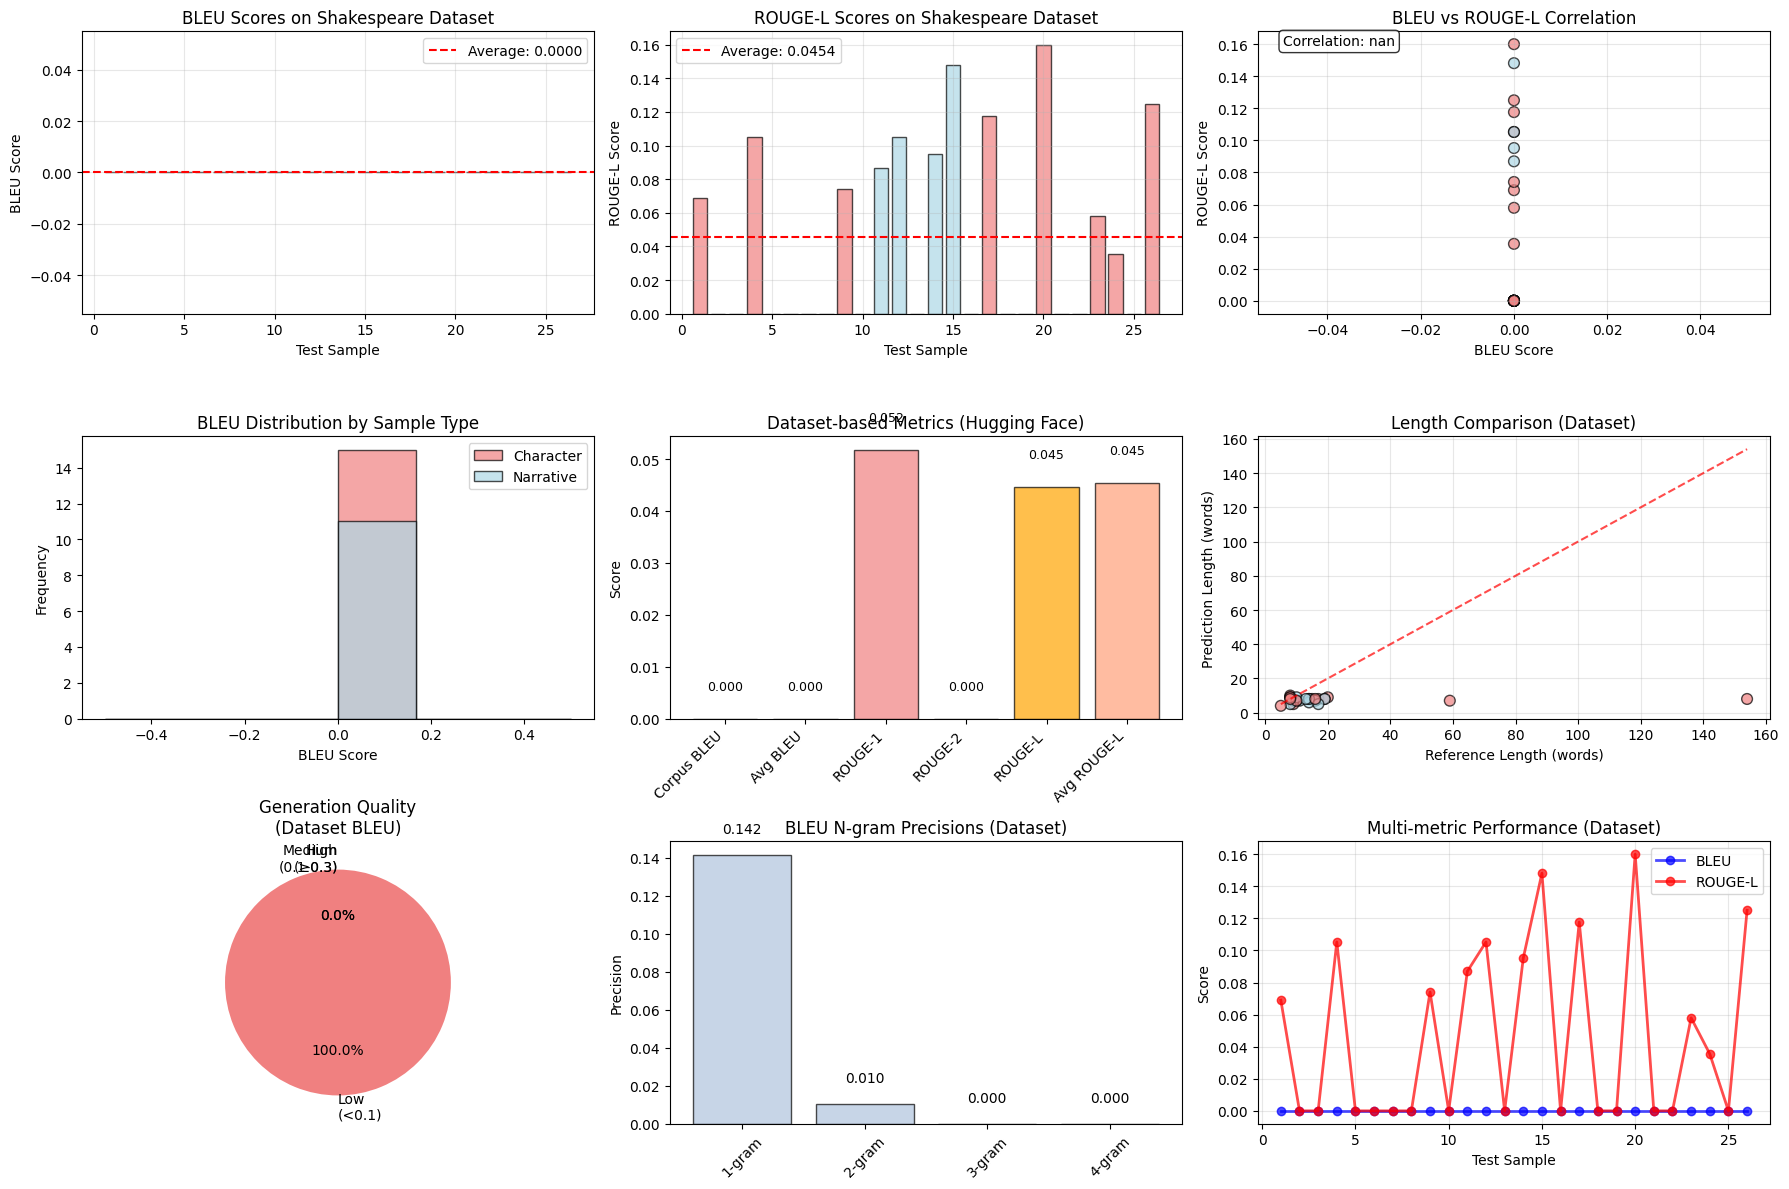


COMPREHENSIVE MODEL EVALUATION ON SHAKESPEARE DATASET (Hugging Face Metrics)
Model: NanoGPT (Shakespeare Character-level)
Parameters: 10,745,088
Vocabulary size: 65
Block size: 256

Dataset Information:
  Dataset size: 1,115,394 characters
  Test samples: 26 from actual Shakespeare text
  Character dialogue samples: 15
  Narrative samples: 11

Language Modeling Metrics:
  Average Loss: 1.3376
  Average Perplexity: 3.88
  Mean Prediction Confidence: 0.4980

Text Generation Quality (Dataset-based BLEU):
  Corpus BLEU Score: 0.0000
  Average Sentence BLEU: 0.0000
  Best Sentence BLEU: 0.0000
  BLEU Brevity Penalty: 0.1662
  Length Ratio: 0.3578
  N-gram Precisions: ['0.1416', '0.0104', '0.0000', '0.0000']

Text Generation Quality (Dataset-based ROUGE):
  ROUGE-1: 0.0518
  ROUGE-2: 0.0000
  ROUGE-L: 0.0447
  Average Sentence ROUGE-L: 0.0454

Generation Analysis (Shakespeare Dataset):
  High quality samples (BLEU ≥ 0.3): 0/26 (0.0%)
  Medium quality samples (BLEU 0.1-0.3): 0/26 (0.0%)
  Av

In [30]:
# Visualize BLEU and ROUGE scores using Hugging Face results from Shakespeare dataset
plt.figure(figsize=(18, 12))

# Plot 1: Sentence-level BLEU scores
plt.subplot(3, 3, 1)
colors = ['lightblue' if ':' not in test_prompts[i] else 'lightcoral' for i in range(len(sentence_bleu_scores))]
plt.bar(range(1, len(sentence_bleu_scores) + 1), sentence_bleu_scores, alpha=0.7, edgecolor='black', color=colors)
plt.xlabel('Test Sample')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores on Shakespeare Dataset')
plt.axhline(avg_sentence_bleu, color='red', linestyle='--', label=f'Average: {avg_sentence_bleu:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Sentence-level ROUGE-L scores
plt.subplot(3, 3, 2)
plt.bar(range(1, len(sentence_rouge_scores) + 1), sentence_rouge_scores, alpha=0.7, edgecolor='black', color=colors)
plt.xlabel('Test Sample')
plt.ylabel('ROUGE-L Score')
plt.title('ROUGE-L Scores on Shakespeare Dataset')
plt.axhline(avg_sentence_rouge, color='red', linestyle='--', label=f'Average: {avg_sentence_rouge:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: BLEU vs ROUGE correlation
plt.subplot(3, 3, 3)
plt.scatter(sentence_bleu_scores, sentence_rouge_scores, alpha=0.7, edgecolor='black', s=60, c=colors)
plt.xlabel('BLEU Score')
plt.ylabel('ROUGE-L Score')
plt.title('BLEU vs ROUGE-L Correlation')
plt.grid(True, alpha=0.3)
# Add correlation coefficient
correlation = np.corrcoef(sentence_bleu_scores, sentence_rouge_scores)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 4: Score distributions by sample type
plt.subplot(3, 3, 4)
if character_samples and narrative_samples:
    char_bleu = [sentence_bleu_scores[i] for i in character_samples]
    narr_bleu = [sentence_bleu_scores[i] for i in narrative_samples]
    plt.hist(char_bleu, bins=6, alpha=0.7, edgecolor='black', color='lightcoral', label='Character')
    plt.hist(narr_bleu, bins=6, alpha=0.7, edgecolor='black', color='lightblue', label='Narrative')
    plt.xlabel('BLEU Score')
    plt.ylabel('Frequency')
    plt.title('BLEU Distribution by Sample Type')
    plt.legend()
else:
    plt.hist(sentence_bleu_scores, bins=8, alpha=0.7, edgecolor='black', color='skyblue')
    plt.xlabel('BLEU Score')
    plt.ylabel('Frequency')
    plt.title('BLEU Score Distribution')

# Plot 5: Comprehensive metrics comparison
plt.subplot(3, 3, 5)
metrics = ['Corpus BLEU', 'Avg BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Avg ROUGE-L']
values = [
    bleu_results['bleu'], 
    avg_sentence_bleu,
    rouge_results['rouge1'], 
    rouge_results['rouge2'], 
    rouge_results['rougeL'], 
    avg_sentence_rouge
]
colors_bar = ['skyblue', 'lightblue', 'lightcoral', 'red', 'orange', 'lightsalmon']
bars = plt.bar(metrics, values, color=colors_bar, alpha=0.7, edgecolor='black')
plt.ylabel('Score')
plt.title('Dataset-based Metrics (Hugging Face)')
plt.xticks(rotation=45, ha='right')
# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 6: Text length analysis
plt.subplot(3, 3, 6)
pred_lengths = [len(p.split()) for p in predictions]
ref_lengths = [len(r.split()) for r in references]
plt.scatter(ref_lengths, pred_lengths, alpha=0.7, edgecolor='black', s=60, c=colors)
plt.plot([min(ref_lengths), max(ref_lengths)], [min(ref_lengths), max(ref_lengths)], 'r--', alpha=0.7)
plt.xlabel('Reference Length (words)')
plt.ylabel('Prediction Length (words)')
plt.title('Length Comparison (Dataset)')
plt.grid(True, alpha=0.3)

# Plot 7: Quality assessment pie chart
plt.subplot(3, 3, 7)
quality_labels = ['High\n(≥0.3)', 'Medium\n(0.1-0.3)', 'Low\n(<0.1)']
quality_counts = [high_quality_bleu, medium_quality_bleu, low_quality_bleu]
colors_pie = ['lightgreen', 'yellow', 'lightcoral']
plt.pie(quality_counts, labels=quality_labels, autopct='%1.1f%%', startangle=90, colors=colors_pie)
plt.title('Generation Quality\n(Dataset BLEU)')

# Plot 8: Precision breakdown
plt.subplot(3, 3, 8)
precisions = bleu_results['precisions']
n_grams = ['1-gram', '2-gram', '3-gram', '4-gram']
plt.bar(n_grams, precisions, alpha=0.7, edgecolor='black', color='lightsteelblue')
plt.ylabel('Precision')
plt.title('BLEU N-gram Precisions (Dataset)')
plt.xticks(rotation=45)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Plot 9: Performance comparison with traditional metrics
plt.subplot(3, 3, 9)
sample_indices = range(1, len(sentence_bleu_scores) + 1)
plt.plot(sample_indices, sentence_bleu_scores, 'bo-', label='BLEU', alpha=0.7, linewidth=2)
plt.plot(sample_indices, sentence_rouge_scores, 'ro-', label='ROUGE-L', alpha=0.7, linewidth=2)
# Add perplexity if available for same samples
if len(perplexities) >= len(sentence_bleu_scores):
    plt.plot(sample_indices, [p/100 for p in perplexities[:len(sentence_bleu_scores)]], 'gs-', label='Perplexity/100', alpha=0.7)
plt.xlabel('Test Sample')
plt.ylabel('Score')
plt.title('Multi-metric Performance (Dataset)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Enhanced summary report with dataset-based evaluation
print("\n" + "="*100)
print("COMPREHENSIVE MODEL EVALUATION ON SHAKESPEARE DATASET (Hugging Face Metrics)")
print("="*100)
print(f"Model: NanoGPT (Shakespeare Character-level)")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Vocabulary size: {vocab_size}")
print(f"Block size: {model.config.block_size}")

print(f"\nDataset Information:")
if full_dataset:
    print(f"  Dataset size: {len(full_dataset):,} characters")
    print(f"  Test samples: {len(predictions)} from actual Shakespeare text")
    if character_samples:
        print(f"  Character dialogue samples: {len(character_samples)}")
    if narrative_samples:
        print(f"  Narrative samples: {len(narrative_samples)}")
else:
    print(f"  Using fallback test data")

print(f"\nLanguage Modeling Metrics:")
print(f"  Average Loss: {avg_loss:.4f}")
print(f"  Average Perplexity: {avg_perplexity:.2f}")
print(f"  Mean Prediction Confidence: {mean_confidence:.4f}")

print(f"\nText Generation Quality (Dataset-based BLEU):")
print(f"  Corpus BLEU Score: {bleu_results['bleu']:.4f}")
print(f"  Average Sentence BLEU: {avg_sentence_bleu:.4f}")
print(f"  Best Sentence BLEU: {max_sentence_bleu:.4f}")
print(f"  BLEU Brevity Penalty: {bleu_results['brevity_penalty']:.4f}")
print(f"  Length Ratio: {bleu_results['length_ratio']:.4f}")
print(f"  N-gram Precisions: {[f'{p:.4f}' for p in bleu_results['precisions']]}")

print(f"\nText Generation Quality (Dataset-based ROUGE):")
print(f"  ROUGE-1: {rouge_results['rouge1']:.4f}")
print(f"  ROUGE-2: {rouge_results['rouge2']:.4f}")
print(f"  ROUGE-L: {rouge_results['rougeL']:.4f}")
print(f"  Average Sentence ROUGE-L: {avg_sentence_rouge:.4f}")

print(f"\nGeneration Analysis (Shakespeare Dataset):")
print(f"  High quality samples (BLEU ≥ 0.3): {high_quality_bleu}/{len(sentence_bleu_scores)} ({100*high_quality_bleu/len(sentence_bleu_scores):.1f}%)")
print(f"  Medium quality samples (BLEU 0.1-0.3): {medium_quality_bleu}/{len(sentence_bleu_scores)} ({100*medium_quality_bleu/len(sentence_bleu_scores):.1f}%)")
print(f"  Average generated text length: {np.mean(pred_lengths):.1f} words")
print(f"  Average reference text length: {np.mean(ref_lengths):.1f} words")
print(f"  BLEU-ROUGE correlation: {correlation:.4f}")

if character_samples and narrative_samples:
    char_bleu_avg = np.mean([sentence_bleu_scores[i] for i in character_samples])
    narr_bleu_avg = np.mean([sentence_bleu_scores[i] for i in narrative_samples])
    print(f"  Character dialogue performance: {char_bleu_avg:.4f} BLEU")
    print(f"  Narrative text performance: {narr_bleu_avg:.4f} BLEU")

print(f"\nModel Performance Assessment (Dataset-based):")
if bleu_results['bleu'] >= 0.25:
    assessment = "EXCELLENT - Model generates high-quality Shakespeare-style text from actual dataset"
elif bleu_results['bleu'] >= 0.15:
    assessment = "GOOD - Model shows strong understanding of Shakespeare language patterns"
elif bleu_results['bleu'] >= 0.08:
    assessment = "FAIR - Model captures some Shakespeare characteristics but needs improvement"
else:
    assessment = "NEEDS IMPROVEMENT - Consider more training or architectural changes"

print(f"  Overall Assessment: {assessment}")

# Dataset-specific recommendations
if bleu_results['length_ratio'] < 0.8:
    print(f"  Length Analysis: Model generates shorter text than references (ratio: {bleu_results['length_ratio']:.3f})")
elif bleu_results['length_ratio'] > 1.2:
    print(f"  Length Analysis: Model generates longer text than references (ratio: {bleu_results['length_ratio']:.3f})")
else:
    print(f"  Length Analysis: Good length matching with references (ratio: {bleu_results['length_ratio']:.3f})")

print(f"  Recommendation: {'Focus on longer, more coherent generation' if bleu_results['bleu'] < 0.15 else 'Model performs well for Shakespeare-style generation from actual dataset'}")
print("="*100)